In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from deap import creator, base, tools, gp, algorithms
import warnings
warnings.filterwarnings("ignore")

# Load data
train_data = pd.read_csv('adult_training.csv')
test_data = pd.read_csv('adult_test.csv')
# Display basic information about the data and first few rows
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             5200 non-null   int64 
 1   workclass       5200 non-null   object
 2   education       5200 non-null   object
 3   marital-status  5200 non-null   object
 4   relationship    5200 non-null   object
 5   race            5200 non-null   object
 6   sex             5200 non-null   object
 7   capital-gain    5200 non-null   int64 
 8   capital-loss    5200 non-null   int64 
 9   hours-per-week  5200 non-null   int64 
 10  native-country  5200 non-null   object
 11  income          5200 non-null   object
dtypes: int64(4), object(8)
memory usage: 487.6+ KB


(None,
    age         workclass  education      marital-status   relationship   race  \
 0   28           Private  Bachelors       Never-married  Not-in-family  White   
 1   34  Self-emp-not-inc  Bachelors  Married-civ-spouse        Husband  Black   
 2   32           Private  Bachelors       Never-married  Not-in-family  Black   
 3   46           Private  Bachelors            Divorced  Not-in-family  White   
 4   44           Private  Bachelors  Married-civ-spouse        Husband  White   
 
       sex  capital-gain  capital-loss  hours-per-week native-country income  
 0    Male             0             0              40  United-States  <=50K  
 1    Male             0          1887              48  United-States   >50K  
 2  Female             0             0              40  United-States  <=50K  
 3    Male             0             0              40         Others  <=50K  
 4    Male             0             0              50  United-States   >50K  )

In [2]:


# Data preprocessing
# Handling missing values and encoding
train_data = train_data.replace('?', pd.NA).dropna()
label_encoder = LabelEncoder()
train_data['income'] = label_encoder.fit_transform(train_data['income'])
train_data = pd.get_dummies(train_data, drop_first=True)

# Feature scaling
scaler = StandardScaler()
train_features = scaler.fit_transform(train_data.drop('income', axis=1))
train_target = train_data['income']

In [3]:
# GP parameters
POPULATION_SIZE = 250
P_CROSSOVER = 0.7
P_MUTATION = 0.1
MAX_GENERATIONS = 40
HALL_OF_FAME_SIZE = 5
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 7
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 3

# Custom functions for GP
def safe_div(x, y):
    try:
        if abs(y) < 1e-6:
            return 1
        else:
            return x / y
    except (TypeError, ZeroDivisionError):
        return 1

def square(x):
    return x * x

def cube(x):
    return x * x * x

def limit_output(func, data):
    try:
        return min(1e6, max(-1e6, func(*data)))
    except OverflowError:
        return 1e6

In [4]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

pset = gp.PrimitiveSet("MAIN", len(train_features[0]), prefix="X")
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(safe_div, 2)
pset.addPrimitive(square, 1)
pset.addPrimitive(cube, 1)

# Fitness function
def refined_fitness_function(individual, data, target):
    func = gp.compile(expr=individual, pset=pset)
    predictions = [limit_output(func, row) for row in data]
    mse = mean_squared_error(target, predictions)
    return (1 / (1 + mse),)  # Inverse of MSE to make it a maximization problem

# Toolbox and genetic operations
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", refined_fitness_function, data=train_features, target=train_target)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

pop = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, stats, halloffame=hof)

# Display the best individual and its fitness value
best_individual = hof[0]
best_fitness = best_individual.fitness.values[0]


print("Best Individual:", best_individual)
print("Best Fitness:", best_fitness)

gen	nevals	avg      	min        	max     
0  	250   	0.0156304	1.07416e-12	0.618679
1  	176   	0.0606535	1.46632e-11	0.748848
2  	180   	0.123892 	7.89074e-12	0.748848
3  	178   	0.251154 	1.63583e-12	0.748848
4  	181   	0.411384 	1.40713e-12	0.760679
5  	176   	0.477104 	4.66867e-12	0.760679
6  	185   	0.520755 	2.95119e-12	0.763682
7  	178   	0.533288 	2.15947e-12	0.761682
8  	188   	0.543279 	1.0775e-12 	0.761682
9  	171   	0.597507 	1.08582e-12	0.767868
10 	177   	0.580203 	1.07705e-12	0.767868
11 	189   	0.607228 	1.07716e-12	0.767868
12 	192   	0.607929 	1.07705e-12	0.767868
13 	182   	0.623221 	1.08041e-12	0.767868
14 	181   	0.621778 	1.08041e-12	0.77427 
15 	188   	0.613381 	1.07951e-12	0.77427 
16 	189   	0.640184 	1.14336e-12	0.774732
17 	181   	0.64869  	1.05477e-12	0.774732
18 	193   	0.614574 	1.26552e-12	0.77117 
19 	176   	0.652645 	1.05477e-12	0.77117 
20 	188   	0.629176 	1.05477e-12	0.774732
21 	194   	0.635888 	1.05477e-12	0.775427
22 	179   	0.667409 	1.4092e-12 	0

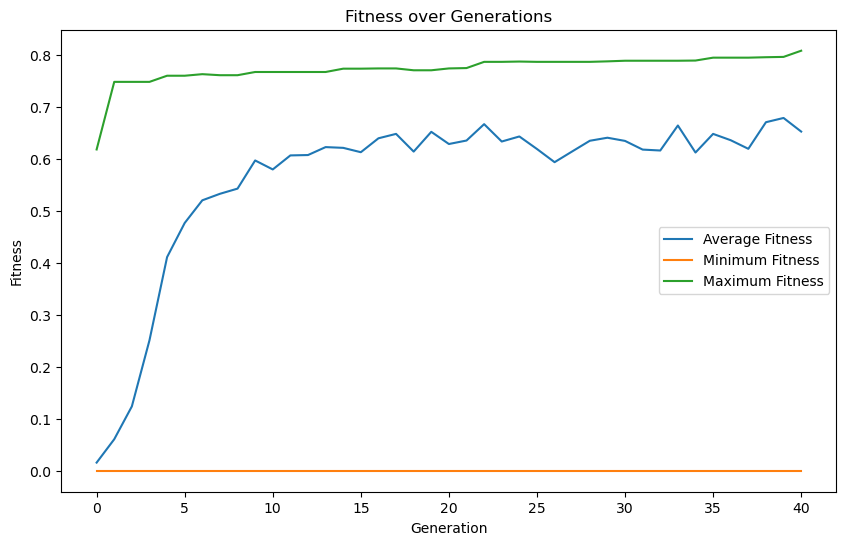

In [5]:
import matplotlib.pyplot as plt
from deap import gp

# Visualization 1: Fitness Over Generations
def plot_fitness_over_generations(log):
    gen = log.select("gen")
    avg_fit = log.select("avg")
    min_fit = log.select("min")
    max_fit = log.select("max")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fit, label="Average Fitness")
    plt.plot(gen, min_fit, label="Minimum Fitness")
    plt.plot(gen, max_fit, label="Maximum Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations")
    plt.legend()
    plt.show()

plot_fitness_over_generations(log)



In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

test_data = test_data.replace('?', pd.NA).dropna()
test_data = pd.get_dummies(test_data, drop_first=True)

def predict_gp_individual(individual, data, pset):
    func = gp.compile(expr=individual, pset=pset)
    predictions = np.round([func(*row) for row in data.values])  # Use .values to get a numpy representation
    return predictions.astype(int)  # Convert to int if necessary, as Kaggle might expect integer labels
# Predict the test set using the best GP individual
test_predictions = predict_gp_individual(best_individual, test_data, pset)



# Predict the test set using the best GP individual
test_predictions = predict_gp_individual(best_individual, test_data, pset)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame({'ID': range(1, len(test_predictions) + 1), 'income': test_predictions})
predictions_df.to_csv('test_predictions6.csv', index=False)

# Check the number of rows in the test predictions CSV file
num_rows = len(predictions_df)
print(f"Number of rows in the test predictions CSV file: {num_rows}")

# Create a new DataFrame with index and income columns
output_df = pd.DataFrame({
    'index': range(len(predictions_df)),
    'income': predictions_df['income']
})

# Save the DataFrame to a CSV file
output_df.to_csv('test_predictions_formatted3.csv', index=False)


Number of rows in the test predictions CSV file: 10402


In [7]:
test_data.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week',
       'workclass_Private', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Some-college',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Wife', 'race_Black', 'race_White', 'sex_Male',
       'native-country_United-States'],
      dtype='object')

In [8]:
predictions_df


,ID,income
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
10397,10398,1
10398,10399,1
10399,10400,1
10400,10401,1


In [9]:
test_data.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_Private,workclass_Self-emp-not-inc,workclass_State-gov,education_Doctorate,education_HS-grad,education_Masters,education_Some-college,marital-status_Married-civ-spouse,marital-status_Never-married,relationship_Not-in-family,relationship_Other-relative,relationship_Wife,race_Black,race_White,sex_Male,native-country_United-States
0,33,3325,0,50,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1
1,58,0,0,40,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1
2,30,0,0,60,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1
3,26,0,0,20,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1
4,43,0,0,60,0,0,1,0,1,0,0,0,1,1,0,0,0,1,1,1


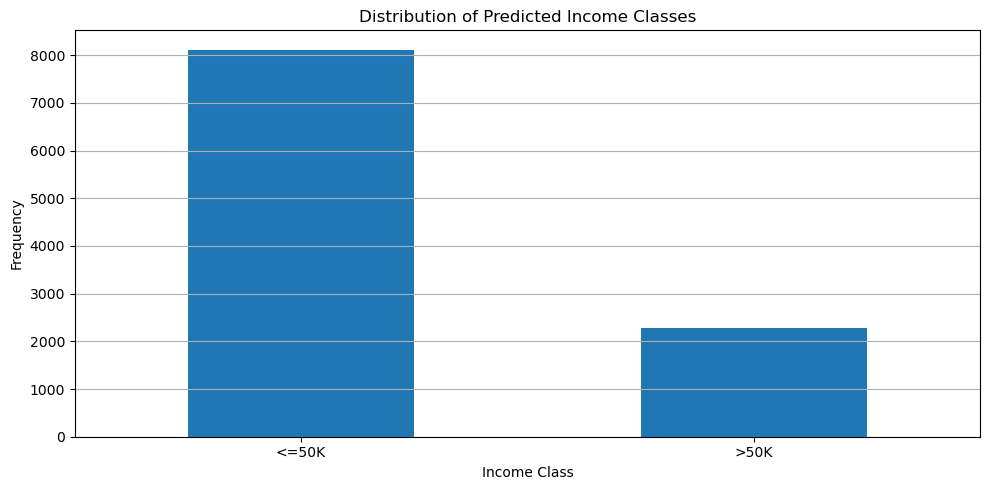

In [10]:
import pandas as pd

# Load the predictions CSV file
predictions_df = pd.read_csv('test_predictions.csv')

# Create a histogram for predicted values
fig, ax = plt.subplots(figsize=(10, 5))

predictions_df['income'].value_counts().plot(kind='bar')

plt.xlabel('Income Class')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Income Classes')
plt.xticks(ticks=[0, 1], labels=['<=50K', '>50K'], rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()